<a href="https://colab.research.google.com/github/jessifebria/TSP_Rute_Penyebaran_Vaksin_Yogyakarta/blob/main/TSP_Rute_Penyebaran_Vaksin_Yogyakarta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# tsp

<table align="left">
<td>
<a href="https://colab.research.google.com/github/google/or-tools/blob/master/examples/notebook/constraint_solver/tsp.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/master/tools/colab_32px.png"/>Run in Google Colab</a>
</td>
<td>
<a href="https://github.com/google/or-tools/blob/master/ortools/constraint_solver/samples/tsp.py"><img src="https://raw.githubusercontent.com/google/or-tools/master/tools/github_32px.png"/>View source on GitHub</a>
</td>
</table>

First, you must install [ortools](https://pypi.org/project/ortools/) package in this colab.

In [113]:
!pip install geopandas

In [114]:
!pip install ortools

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [264]:
# Copyright 2010-2018 Google LLC
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# [START program]
"""Simple Travelling Salesman Problem.

A description of the problem can be found here:
http://en.wikipedia.org/wiki/Travelling_salesman_problem.
"""

# [START import]
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
# [END import]
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 
import numpy as np

%matplotlib inline

data = pd.read_csv('/content/drive/My Drive/DATA.csv')
dataused = data[['NamaFaskes','LatLongFaskes','AlamatFaskes', 'KotaKab']]
dataused.drop(dataused.index[14], inplace=True)

dataused.reset_index(drop=True, inplace=True)              
datatsp = []

i=0


for i in range(0,len(dataused)-1):
  # print(data)
  temparray = dataused['LatLongFaskes'][i].lstrip(' ')[28:].split(',')
  # print(temparray)
  temp = []
  for dataa in temparray:
    # print(i, dataa)
    temp.append(float(dataa))
  datatsp.append(tuple(temp))
  # print(datatsp)
  # print(datatsp[i])
  i+=1

# [START data_model]
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Locations in block units
    locations = \
            datatsp
    # Convert locations in meters using a city block dimension of 114m x 80m.
    data['locations'] = [(l[0] * 114, l[1] * 80) for l in locations]
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data
    # [END data_model]


# [START distance_callback]
def create_distance_callback(data, manager):
    """Creates callback to return distance between points."""
    distances_ = {}
    index_manager_ = manager
    # precompute distance between location to have distance callback in O(1)
    for from_counter, from_node in enumerate(data['locations']):
        distances_[from_counter] = {}
        for to_counter, to_node in enumerate(data['locations']):
            if from_counter == to_counter:
                distances_[from_counter][to_counter] = 0
            else:
                distances_[from_counter][to_counter] = (
                    abs(from_node[0] - to_node[0]) +
                    abs(from_node[1] - to_node[1]))

    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = index_manager_.IndexToNode(from_index)
        to_node = index_manager_.IndexToNode(to_index)
        return distances_[from_node][to_node]

    return distance_callback
    # [END distance_callback]


result = []

# [START solution_printer]
def print_solution(manager, routing, assignment):
    """Prints assignment on console."""
    print('Objective: {}'.format(assignment.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        result.append(manager.IndexToNode(index))
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    plan_output += 'Distance of the route: {}m\n'.format(route_distance)
    print(plan_output)
    # [END solution_printer]


"""Entry point of the program."""
# Instantiate the data problem.
# [START data]
data = create_data_model()
# [END data]

# Create the routing index manager.
# [START index_manager]
manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                       data['num_vehicles'], data['depot'])
# [END index_manager]

# Create Routing Model.
# [START routing_model]
routing = pywrapcp.RoutingModel(manager)
# [END routing_model]

# Create and register a transit callback.
# [START transit_callback]
distance_callback = create_distance_callback(data, manager)
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# [END transit_callback]

# Define cost of each arc.
# [START arc_cost]
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
# [END arc_cost]

# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
# [END parameters]

# Solve the problem.
# [START solve]
assignment = routing.SolveWithParameters(search_parameters)
# [END solve]

# Print solution on console.
# [START print_solution]
if assignment:
    print_solution(manager, routing, assignment)
# [END print_solution]



Objective: 225
Route for vehicle 0:
 0 -> 2 -> 5 -> 1 -> 4 -> 3 -> 32 -> 33 -> 34 -> 28 -> 30 -> 36 -> 42 -> 45 -> 43 -> 44 -> 31 -> 29 -> 38 -> 26 -> 37 -> 40 -> 16 -> 23 -> 24 -> 46 -> 39 -> 35 -> 41 -> 47 -> 55 -> 57 -> 50 -> 56 -> 27 -> 49 -> 48 -> 58 -> 51 -> 52 -> 53 -> 54 -> 8 -> 12 -> 11 -> 25 -> 18 -> 21 -> 22 -> 20 -> 19 -> 7 -> 9 -> 6 -> 15 -> 13 -> 17 -> 10 -> 14 -> 0
Distance of the route: 225m



/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [265]:
dataused['NamaFaskes'] = dataused['NamaFaskes'].str.replace("\r\n","")

dataused.loc[dataused['KotaKab'].str.split("Kode Faskes dan Alamat Rumah Sakit BPJS di\r\n ").str.get(0) != "Kode Faskes dan Alamat Rumah Sakit BPJS di\r\n ", 'KotaKab'] =  dataused['KotaKab'].str.split('Kode Faskes dan Alamat Rumah Sakit BPJS di').str.get(1)
dataused.loc[dataused['KotaKab'].str.split("Kode Faskes dan Alamat Rumah Sakit BPJS di\r\n ").str.get(0) == "Kode Faskes dan Alamat Rumah Sakit BPJS di\r\n ", 'KotaKab'] =  dataused['KotaKab'].str.split('Kode Faskes dan Alamat Rumah Sakit BPJS di\r\n ').str.get(1)

# dataused['KotaKab'] = dataused['KotaKab'].str.split('Kode Faskes dan Alamat Rumah Sakit BPJS di ').str.get(1)
# dataused['KotaKab'] = dataused['KotaKab'].str.split('\r\n ').str.get(1)
dataused['KotaKab']= dataused['KotaKab'].str.replace("\r\n","")
# print( dataused['KotaKab'].replace('\r\n',''))
print(dataused[dataused["NamaFaskes"]=="RS Rachma Husada"])

Empty DataFrame
Columns: [NamaFaskes, LatLongFaskes, AlamatFaskes, KotaKab]
Index: []


In [266]:
dataused.head(-5)

,NamaFaskes,LatLongFaskes,AlamatFaskes,KotaKab
0,RSU Rizki Amalia Medika ...,"http://maps.google.co.id/?q=-7.887368,110.074488",Jl. Brosot-Wates Km 5 Jogahan,Kab. Kulon Progo
1,RSu Kharisma Paramedika ...,"http://maps.google.co.id/?q=-7.864705,110.15399","Jl. Khuduri No. 34, Wates",Kab. Kulon Progo
2,RSU Rizki Amalia ...,"http://maps.google.co.id/?q=-7.887412,110.085014",Jl Wates Purworejo Km 10,Kab. Kulon Progo
3,RS Santo Yusup Boro ...,"http://maps.google.co.id/?q=-7.695678,110.223358",Boro Banjarasri Kalibawang,Kab. Kulon Progo
4,RSUD Nyi Ageng Serang ...,"http://maps.google.co.id/?q=-7.821112,110.225525","Jl. Sentolo -Muntilan Km 0,3",Kab. Kulon Progo
5,RSUD Wates ...,"http://maps.google.co.id/?q=-7.86942,110.1413",Jl. Tentara Pelajar Km.1 No.5,Kab. Kulon Progo
6,RS Nur Hidayah ...,"http://maps.google.co.id/?q=-7.8872189,110.384...","Jl. Imogiri Timur Km 11,5",Kab. Bantul
7,RS Permata Husada ...,"http://maps.google.co.id/?q=-7.865656,110.408108",Raya Pleret Km 4,Kab. Bantul
8,RS Rachma Husada ...,"http://maps.google.co.id/?q=-7.829642,110.367641",Parangtritis Km.16 Gerselo Pat,Kab. Bantul
9,RS Rajawali Citra Bantul ...,"http://maps.google.co.id/?q=-7.864631,110.408324","Pleret km 2,5",Kab. Bantul


In [267]:
data_result = []
for i in result:
    data_result.append([dataused['NamaFaskes'][i], datatsp[i][0], datatsp[i][1],dataused['AlamatFaskes'][i], dataused['KotaKab'][i] ])

df_result = pd.DataFrame(data_result, columns=['Nama RS', 'Latitude', 'Longtitude', 'Alamat', 'Kota/Kabupaten'])

df_result.head()

,Nama RS,Latitude,Longtitude,Alamat,Kota/Kabupaten
0,RSU Rizki Amalia Medika ...,-7.887368,110.074488,Jl. Brosot-Wates Km 5 Jogahan,Kab. Kulon Progo
1,RSU Rizki Amalia ...,-7.887412,110.085014,Jl Wates Purworejo Km 10,Kab. Kulon Progo
2,RSUD Wates ...,-7.869420,110.141300,Jl. Tentara Pelajar Km.1 No.5,Kab. Kulon Progo
3,RSu Kharisma Paramedika ...,-7.864705,110.153990,"Jl. Khuduri No. 34, Wates",Kab. Kulon Progo
4,RSUD Nyi Ageng Serang ...,-7.821112,110.225525,"Jl. Sentolo -Muntilan Km 0,3",Kab. Kulon Progo


In [268]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame

yogya_bound = gpd.read_file("/content/drive/MyDrive/yogya/JALAN_LN_25K.shp")
bantul_bound = gpd.read_file("/content/drive/MyDrive/bantul/JALAN_LN_25K.shp")
gunungkidul_bound = gpd.read_file("/content/drive/MyDrive/gunungkidul/JALAN_LN_25K.shp")
sleman_bound = gpd.read_file("/content/drive/MyDrive/sleman/JALAN_LN_25K.shp")
kulonprogo_bound = gpd.read_file("/content/drive/MyDrive/kulonprogo/JALAN_LN_25K.shp")

crs = {'init': 'epsg:4326' }
geometry = [Point(xy) for xy in zip(df_result['Longtitude'], df_result['Latitude'])]
df_result = gpd.GeoDataFrame(df_result, crs=crs, geometry=geometry)



/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [269]:
df_result.head()

,Nama RS,Latitude,Longtitude,Alamat,Kota/Kabupaten,geometry
0,RSU Rizki Amalia Medika ...,-7.887368,110.074488,Jl. Brosot-Wates Km 5 Jogahan,Kab. Kulon Progo,POINT (110.07449 -7.88737)
1,RSU Rizki Amalia ...,-7.887412,110.085014,Jl Wates Purworejo Km 10,Kab. Kulon Progo,POINT (110.08501 -7.88741)
2,RSUD Wates ...,-7.869420,110.141300,Jl. Tentara Pelajar Km.1 No.5,Kab. Kulon Progo,POINT (110.14130 -7.86942)
3,RSu Kharisma Paramedika ...,-7.864705,110.153990,"Jl. Khuduri No. 34, Wates",Kab. Kulon Progo,POINT (110.15399 -7.86470)
4,RSUD Nyi Ageng Serang ...,-7.821112,110.225525,"Jl. Sentolo -Muntilan Km 0,3",Kab. Kulon Progo,POINT (110.22553 -7.82111)


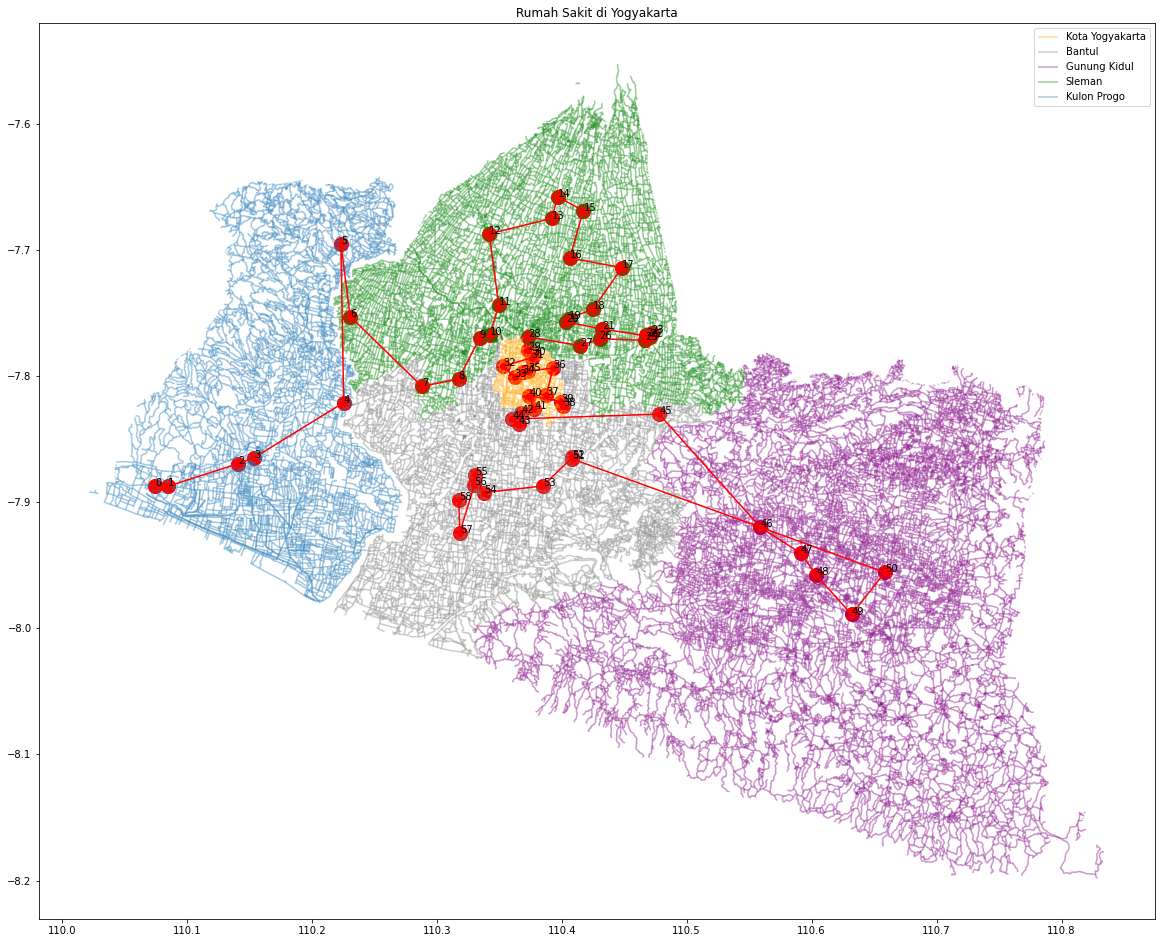

In [270]:

fig, ax = plt.subplots(figsize = (20,20))
yogya_bound.plot(color='orange', ax=ax, alpha = 0.4, label="Kota Yogyakarta" )
bantul_bound.plot(color='grey', ax=ax, alpha = 0.4, label= "Bantul" )
gunungkidul_bound.plot(color='purple', ax=ax, alpha = 0.4, label= "Gunung Kidul")
sleman_bound.plot(color='green', ax=ax, alpha = 0.4, label= "Sleman" )
kulonprogo_bound.plot( ax=ax, alpha = 0.4, label="Kulon Progo" )
df_result.geometry.plot(ax=ax, color = 'red', markersize = 200, alpha=1)
plt.plot(df_result.Longtitude, df_result.Latitude, 'ro-')
for i in range(0, df_result.shape[0]):
  temp = []
  temp.append(df_result.Longtitude[i])
  temp.append(df_result.Latitude[i])
  plt.annotate(str(i),tuple(temp))
plt.title('Rumah Sakit di Yogyakarta')
plt.legend()
plt.show()

In [271]:
df_nama_rs = pd.DataFrame(df_result[["Nama RS", "Alamat", "Kota/Kabupaten"]] )

df_nama_rs

,Nama RS,Alamat,Kota/Kabupaten
0,RSU Rizki Amalia Medika ...,Jl. Brosot-Wates Km 5 Jogahan,Kab. Kulon Progo
1,RSU Rizki Amalia ...,Jl Wates Purworejo Km 10,Kab. Kulon Progo
2,RSUD Wates ...,Jl. Tentara Pelajar Km.1 No.5,Kab. Kulon Progo
3,RSu Kharisma Paramedika ...,"Jl. Khuduri No. 34, Wates",Kab. Kulon Progo
4,RSUD Nyi Ageng Serang ...,"Jl. Sentolo -Muntilan Km 0,3",Kab. Kulon Progo
5,RS Santo Yusup Boro ...,Boro Banjarasri Kalibawang,Kab. Kulon Progo
6,RSU Panti Bhaktiningsih ...,"Jl Godean-Gedongan,Sendangmuly",Kab. Sleman
7,RSU Mitra Sehat ...,"Jalan Wates Km 9, Ngaran",Kab. Sleman
8,PKU Muhammadiyah Gamping ...,"JL.Wates Km.5,5, Ambarketawang",Kab. Sleman
9,RS Queen Latifa ...,Jalan Siliwangi (Ring Road Bar,Kab. Sleman
